In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from myspace import MySpace
from sklearn.mixture import GaussianMixture

First, simulate some fake position and velocity data. Note that these have to be relative to the solar position, so if you are working with simulation data, you have to pick a location for the sun.

In [2]:
rnd = np.random.RandomState(42)
N = 100_000  # number of simulated data points

# This might seem crazy/convoluted...it is!
sim_K = 6
sim_gmm = GaussianMixture(n_components=sim_K, 
                          random_state=rnd)

sim_Ns = (N * rnd.uniform(0, 1, size=sim_K-1) / sim_K).astype(int)
sim_Ns = np.concatenate((sim_Ns, [N - sum(sim_Ns)]))

sim_mu = rnd.uniform(-5, 5, size=(sim_K, 3))

sim_C = rnd.normal(size=(sim_K, 3, 3))
sim_C = np.array([0.5 * (sim_C[k] @ sim_C[k].T) 
                  for k in range(sim_K)])

tmp = np.concatenate([
    rnd.multivariate_normal(sim_mu[k], sim_C[k], size=sim_Ns[k]) 
    for k in range(sim_K)])
sim_gmm.fit(tmp)

# Now we know truth for the reference distribution, we make the data:
x = rnd.uniform(-300, 300, size=(N, 2))
x = np.hstack((x, rnd.normal(0, 50, size=(N, 1))))

sim_Aij = rnd.uniform(-5e-3, 5e-3, size=(3, 3))
init_v, _ = sim_gmm.sample(N)
v = init_v + np.einsum('ij,nj->ni', sim_Aij, x)

Text(0.5, 1.0, 'simulated position-dependent velocities')

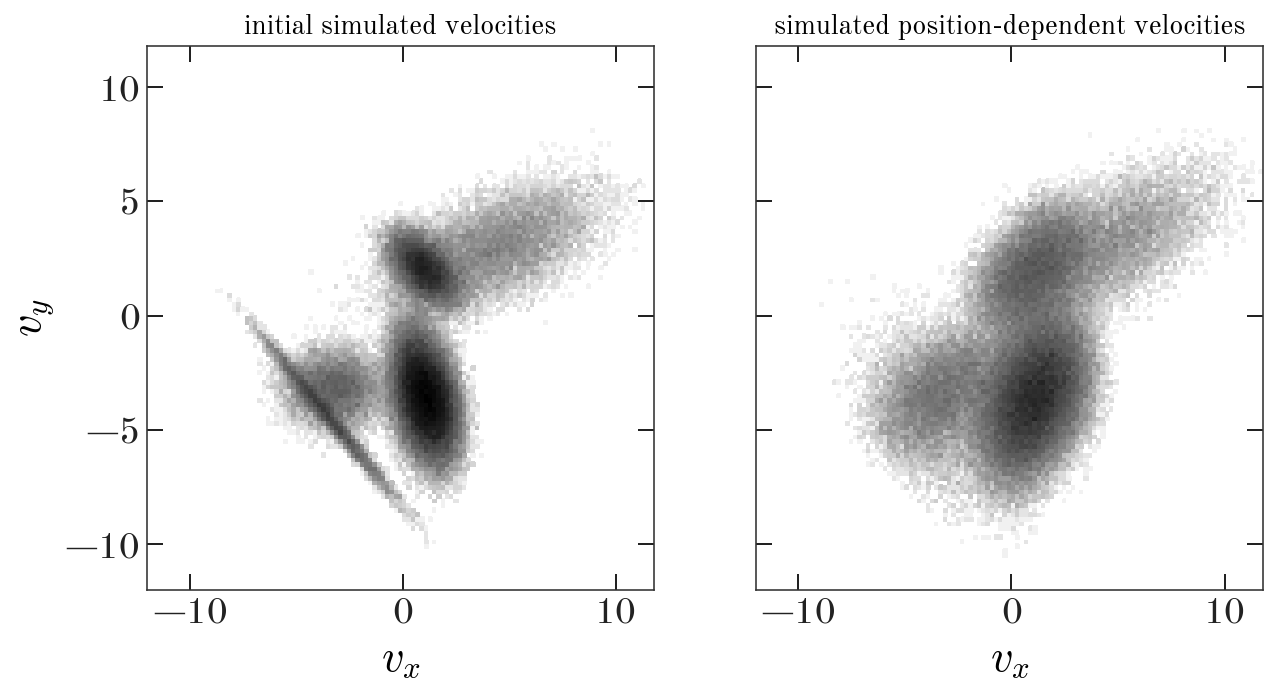

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

style = dict(cmap='Greys',
             bins=np.arange(-12, 12, 0.2),
             norm=mpl.colors.LogNorm())

axes[0].hist2d(init_v[:,0], init_v[:,1], **style)
axes[1].hist2d(v[:,0], v[:,1], **style);

for ax in axes:
    ax.set_xlabel('$v_x$')
axes[0].set_ylabel('$v_y$')

axes[0].set_title('initial simulated velocities', fontsize=14)
axes[1].set_title('simulated position-dependent velocities', fontsize=14)

At this point, let's forget that we generated this simulated data. We are given cartesian positions and velocities relative to the sun, `x` and `v`, and we want to learn the position-dependent transformation matrix that transforms the velocities of stars in a region around the sun to be most similar to the velocity distribution very local to the sun.

Let's start by defining what we mean by "local". In principle, with data, this will require some iteration. We want a region that's small enough that velocity-space features are sharp, but big enough that we have many stars. Here, I'll arbitrarily set my threshold for the local region to 150 length units:

In [4]:
local_mask = np.linalg.norm(x, axis=1) < 150
local_mask.sum()

17398

Text(0.5, 1.0, 'local sample')

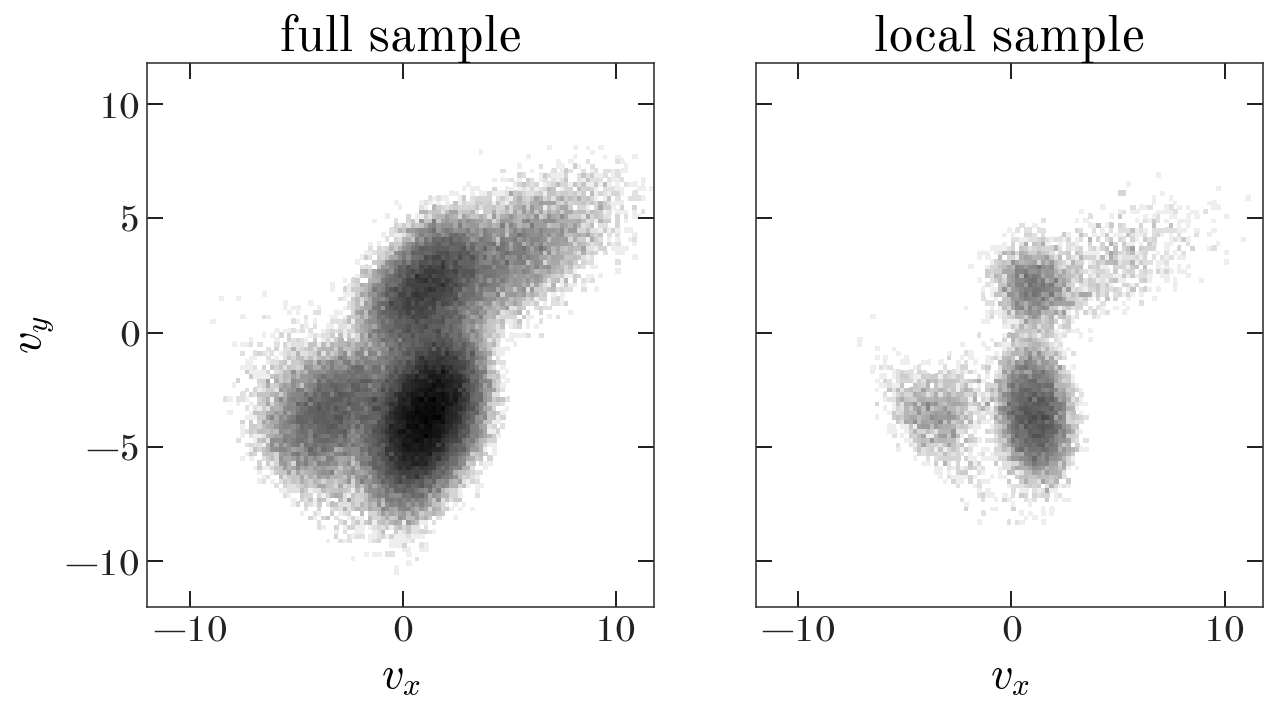

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

style = dict(cmap='Greys',
             bins=np.arange(-12, 12, 0.2),
             norm=mpl.colors.LogNorm())

axes[0].hist2d(v[:,0], v[:,1], **style)
axes[1].hist2d(v[local_mask, 0], v[local_mask, 1], **style);

for ax in axes:
    ax.set_xlabel('$v_x$')
axes[0].set_ylabel('$v_y$')

axes[0].set_title('full sample')
axes[1].set_title('local sample')

Now we need to fit a GMM to the local sample with some number of components. Obviously with a galaxy simulation or with real data, we don't know how to set the number of mixture components a priori, so we might need to do some cross-validation here. I'll just set this to a magic number (different from the "true" number that I simulated the data with!):

In [6]:
local_gmm = GaussianMixture(n_components=8)
local_gmm.fit(v[local_mask])

GaussianMixture(n_components=8)

Now we can set up our instance of `MySpace`. We will tell it that we only want to go out to linear order in x by specifying `terms=['x']`. If we want more terms, we could have done, e.g., `terms=['x', 'xv', 'xx']` etc.

In [7]:
myspace = MySpace(local_gmm, terms=['x'])

Now we need to define our training sample. Here, we'll take all stars out to a length unit of 300, but again, we will need to set this heuristically with your simulations or the real data:

In [8]:
train_mask = np.linalg.norm(x, axis=1) < 300
train_mask.sum()

76356

In [9]:
res, tensors = myspace.fit(x[train_mask], v[train_mask])

In [10]:
tensors['Aij']

array([[-0.00497065, -0.00281702,  0.00193822],
       [-0.0048916 , -0.00396551,  0.00027073],
       [-0.00349226, -0.00098605,  0.00345882]])

In [11]:
- sim_Aij

array([[-0.00495279, -0.0028347 ,  0.00191205],
       [-0.00489291, -0.00396368,  0.00041034],
       [-0.00352567, -0.00095425,  0.00346792]])

Woot! It looks like we recovered the (negative) of the "true" transformation matrix!